# LymphomAI - Méthode d'apprentissage profond pour la segmentation de cellules en cytologie

In [1]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from tqdm import tqdm

### Paramètres et fonctions utiles

In [2]:
# Chemins d'accès des images et des masques

output_dir_benign_images = "dataset/benign/images"
output_dir_benign_masks = "dataset/benign/masks"
output_dir_malignant_images = "dataset/malignant/images"
output_dir_malignant_masks = "dataset/malignant/masks"

batch_size = 8
size = 224

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

def show_images(images, titles=None):
    if len(images) == 0:
        return
     
    if titles is None:
        titles = ['Image %d' % i for i in range(len(images))]
        
    num_images = len(images)
    max_images_per_row = 5
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row 
    num_columns = min(num_images, max_images_per_row)
    
    fig_width = max_images_per_row * 4
    fig_height = num_rows * 4
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
    
    ax_flat = axes.flat
    for idx, ax in enumerate(ax_flat):
        if idx < num_images:
            ax.imshow(images[idx])
            ax.set_title(titles[idx])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()
    plt.close()

COLOR_TO_CLASS = {
    (96, 209, 70): 0,  # 'Lymphocyte non tumoral'
    (222, 30, 36): 1,  # 'Cellule tumorale lymphomateuse'
    (83, 7, 150): 1,   # 'Cellule tumorale non lymphomateuse'
    (25, 107, 35): 0,  # 'PNN'
    (24, 136, 92): 0,  # 'PNE'
    (234, 98, 193): 0, # 'Histiocyte'
    (146, 14, 251): 0, # 'Plasmocyte'
    (255, 255, 255): 2,  # 'background'
    (0, 0, 255): 44, # 'Cellule non annotée ignorées pour l'entraînement'
}

#CLASS_TO_COLOR = {v: k for k, v in COLOR_TO_CLASS.items()}  

CLASS_TO_COLOR = {
    0 : (96, 209, 70),  # 'Autre cellule'
    1 : (222, 30, 36),  # 'Cellule tumorales'
    2 : (255, 255, 255),   # 'background'
    44 : (0, 0, 255), # 'Cellule non annotée ignorées pour l'entraînement'
}


def rgb_to_grayscale_mask(mask):
    """Convertit un masque RGB en niveaux de gris avec des indices entiers (0 à 7) sous forme d'image PIL."""
    mask_array = np.array(mask)
    grayscale_mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)
    
    for rgb, cls in COLOR_TO_CLASS.items():
        match = np.all(mask_array == np.array(rgb), axis=-1)
        grayscale_mask[match] = cls
    
    # Retourner l'image en niveaux de gris sous forme d'image PIL
    return Image.fromarray(grayscale_mask)

def grayscale_to_rgb_mask(mask):
    """Convertit un masque en niveaux de gris vers RGB selon le mapping spécifié."""
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze(0).cpu().numpy()
    
    mask_array = np.array(mask)
    rgb_mask = np.zeros((*mask_array.shape, 3), dtype=np.uint8)

    for cls, rgb in CLASS_TO_COLOR.items():
        match = (mask_array == cls)
        rgb_mask[match] = rgb

    return Image.fromarray(rgb_mask)

Using GPU


### Préparation des données

In [3]:
# Défini les transformations de l'image (augmentation de données et passage en tensor)

class JointTransform:
    def __init__(self, image_transform, mask_transform=None):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, image, mask):
        # Synchroniser les transformations en utilisant la même graine pour que la même transformation soit appliquée à l'image et au masque
        seed = random.randint(0, 2**32)
        torch.manual_seed(seed)
        image = self.image_transform(image)
        
        torch.manual_seed(seed)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convertir le masque en tensor avec des valeurs discrètes après toutes les transformations
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

# Défini le dataset (Image d'entrée, masque de vérité terain et label binaire pour la classification)
class CytologyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        mask = rgb_to_grayscale_mask(mask)
        
        mask = isolate_cells_in_background(mask, image)
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask, label

In [4]:
def split_dataset(image_dir_benign, mask_dir_benign, image_dir_malignant, mask_dir_malignant, test_size=0.1, val_size=0.1):
    
    def get_image_paths(dir_path):
        return [
            os.path.join(dir_path, fname) 
            for fname in sorted(os.listdir(dir_path)) 
            if os.path.isfile(os.path.join(dir_path, fname)) and fname.endswith(('.png', '.jpg', '.jpeg'))
        ]

    benign_images = get_image_paths(image_dir_benign)
    benign_masks = get_image_paths(mask_dir_benign)
    malignant_images = get_image_paths(image_dir_malignant)
    malignant_masks = get_image_paths(mask_dir_malignant)
    
    benign_data = list(zip(benign_images, benign_masks, [0] * len(benign_images)))
    malignant_data = list(zip(malignant_images, malignant_masks, [1] * len(malignant_images)))
    
    # Split les datasets pour chaque classe séparément pour garder un équilibre de classe
    train_benign, temp_benign = train_test_split(benign_data, test_size=test_size + val_size, random_state=42)
    val_benign, test_benign = train_test_split(temp_benign, test_size=test_size / (test_size + val_size), random_state=42)
    
    train_malignant, temp_malignant = train_test_split(malignant_data, test_size=test_size + val_size, random_state=42)
    val_malignant, test_malignant = train_test_split(temp_malignant, test_size=test_size / (test_size + val_size), random_state=42)
    
    # Split les données pour la création d'un dataset d'entraînement, de validation et de test
    min_len = min(len(train_benign), len(train_malignant))
    train_benign = train_benign[:min_len]
    train_malignant = train_malignant[:min_len]
    
    train_data = train_benign + train_malignant
    val_data = val_benign + val_malignant
    test_data = test_benign + test_malignant
    
    # Mélanger les données pour éviter d'avoir des classes consécutives
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data

def create_dataloader(data, transform, batch_size, shuffle=True):
    image_paths = [x[0] for x in data]
    mask_paths = [x[1] for x in data]
    labels = [x[2] for x in data]
    
    dataset = CytologyDataset(image_paths, mask_paths, labels, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
image_transform = transforms.Compose([
    transforms.Resize((size, size)), # Redimensionner les images
    transforms.RandomHorizontalFlip(), # Augmentation via rotation horizontale
    transforms.RandomVerticalFlip(), # Augmentation via rotation verticale
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Augmentation via changement de couleur
    transforms.ToTensor() # Convertir l'image en tensor (Pytorch)
])

mask_transform = transforms.Compose([
    transforms.Resize((size, size), interpolation=Image.NEAREST), # l'interpolation NEAREST permet de garder les valeurs de classe sans moyenné les valeurs pendant le redimensionnement 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

train_transform = JointTransform(image_transform=image_transform, mask_transform=mask_transform)

val_test_transform = JointTransform(
    image_transform=transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ]),
    mask_transform=transforms.Compose([
        transforms.Resize((size, size), interpolation=Image.NEAREST),
    ])
)

train_data, val_data, test_data = split_dataset(
    output_dir_benign_images, output_dir_benign_masks, 
    output_dir_malignant_images, output_dir_malignant_masks
)

print("Train dataset : " , len(train_data))
print("Val dataset : " , len(val_data))
print("Test dataset : ",  len(test_data))


# Création des DataLoaders
train_loader = create_dataloader(train_data, train_transform, batch_size)
val_loader = create_dataloader(val_data, val_test_transform, batch_size)
test_loader = create_dataloader(test_data, val_test_transform, batch_size)

Train dataset :  12088
Val dataset :  1624
Test dataset :  1625


### Elimination des cellules non annotées

In [6]:
def isolate_cells_in_background(mask, image, min_area=200):
    
    mask_array = np.array(mask)
    image_array = np.array(image)

    background_mask = (mask_array == 2)

    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(hsv_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)
    hsv_clahe_image = cv2.merge([h, s, v_clahe])

    gray_image = cv2.cvtColor(cv2.cvtColor(hsv_clahe_image, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_mask = ~binary_mask

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_mask = mask_array.copy()

    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            object_mask = np.zeros_like(binary_mask)
            cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

            cells_in_background = background_mask & (object_mask == 255)
            
            new_mask[cells_in_background] = 44
            
    return Image.fromarray(new_mask)

def test_and_show_images(dataloader, n_images=5):
    for i, (image, mask, updated_mask, label) in enumerate(dataloader):
        if i >= n_images:
            break
            
        original =  grayscale_to_rgb_mask(mask[0])
        updated = grayscale_to_rgb_mask(updated_mask[0])
        
        show_images([image[0], original,updated], ["Image", "Original Mask", "Updated Mask"])


In [7]:
def isolate_cells_in_background(mask, image, min_area=200):
    
    mask_array = np.array(mask)
    image_array = np.array(image)

    background_mask = (mask_array == 2)

    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(hsv_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)
    hsv_clahe_image = cv2.merge([h, s, v_clahe])

    gray_image = cv2.cvtColor(cv2.cvtColor(hsv_clahe_image, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_mask = ~binary_mask

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_mask = mask_array.copy()

    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            object_mask = np.zeros_like(binary_mask)
            cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

            cells_in_background = background_mask & (object_mask == 255)
            
            new_mask[cells_in_background] = 44
            
    return Image.fromarray(new_mask)

def test_and_show_images(dataloader, n_images=5):
    for i, (image, mask, updated_mask, label) in enumerate(dataloader):
        if i >= n_images:
            break
            
        original =  grayscale_to_rgb_mask(mask[0])
        updated = grayscale_to_rgb_mask(updated_mask[0])
        
        show_images([image[0], original,updated], ["Image", "Original Mask", "Updated Mask"])


In [8]:
def isolate_cells_in_background(mask, image, min_area=200):
    
    mask_array = np.array(mask)
    image_array = np.array(image)

    background_mask = (mask_array == 2)

    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(hsv_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)
    hsv_clahe_image = cv2.merge([h, s, v_clahe])

    gray_image = cv2.cvtColor(cv2.cvtColor(hsv_clahe_image, cv2.COLOR_HSV2RGB), cv2.COLOR_RGB2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_mask = ~binary_mask

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_mask = mask_array.copy()

    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            object_mask = np.zeros_like(binary_mask)
            cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

            cells_in_background = background_mask & (object_mask == 255)
            
            new_mask[cells_in_background] = 44
            
    return Image.fromarray(new_mask)

def test_and_show_images(dataloader, n_images=5):
    for i, (image, mask, updated_mask, label) in enumerate(dataloader):
        if i >= n_images:
            break
            
        original =  grayscale_to_rgb_mask(mask[0])
        updated = grayscale_to_rgb_mask(updated_mask[0])
        
        show_images([image[0], original,updated], ["Image", "Original Mask", "Updated Mask"])


Proportions dans le dataset Train:
  Tumorales: 50.00%
  Non-tumorales: 50.00%


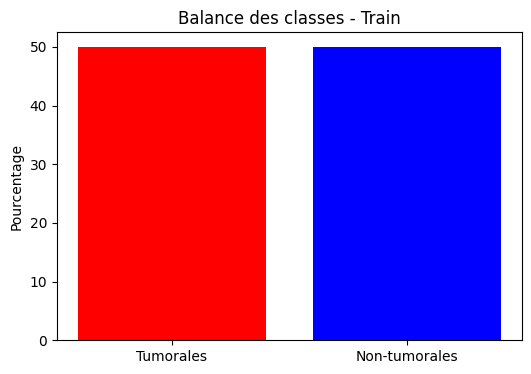

Proportions dans le dataset Validation:
  Tumorales: 46.55%
  Non-tumorales: 53.45%


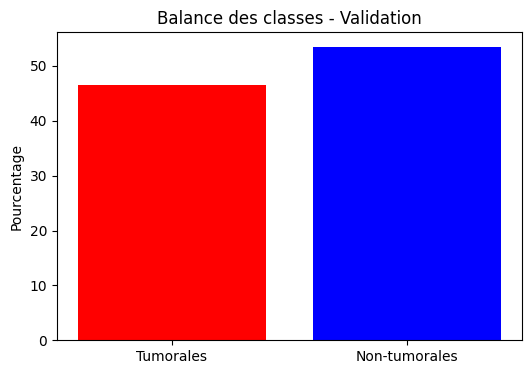

Proportions dans le dataset Test:
  Tumorales: 46.52%
  Non-tumorales: 53.48%


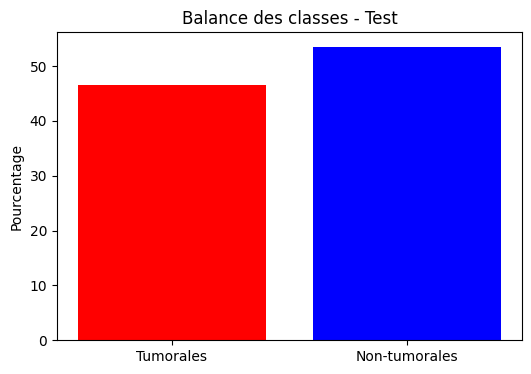

In [9]:
def check_class_balance(dataset, dataset_name=""):
    labels = [x[2] for x in dataset]
    label_count = Counter(labels)
    
    # Calculer les proportions
    total = len(labels)
    tumor_percentage = label_count[1] / total * 100 if 1 in label_count else 0
    non_tumor_percentage = label_count[0] / total * 100 if 0 in label_count else 0
    
    print(f"Proportions dans le dataset {dataset_name}:")
    print(f"  Tumorales: {tumor_percentage:.2f}%")
    print(f"  Non-tumorales: {non_tumor_percentage:.2f}%")
    
    # Affichage
    plt.figure(figsize=(6, 4))
    plt.bar(['Tumorales', 'Non-tumorales'], [tumor_percentage, non_tumor_percentage], color=['r', 'b'])
    plt.title(f"Balance des classes - {dataset_name}")
    plt.ylabel('Pourcentage')
    plt.show()

# Vérification de la balance des classes dans chaque dataset
check_class_balance(train_data, "Train")
check_class_balance(val_data, "Validation")
check_class_balance(test_data, "Test")

torch.Size([224, 224])
Couleurs du mask
[ 1  2 44]
Couleurs du mask traitement
[  0  30  36 222 255]


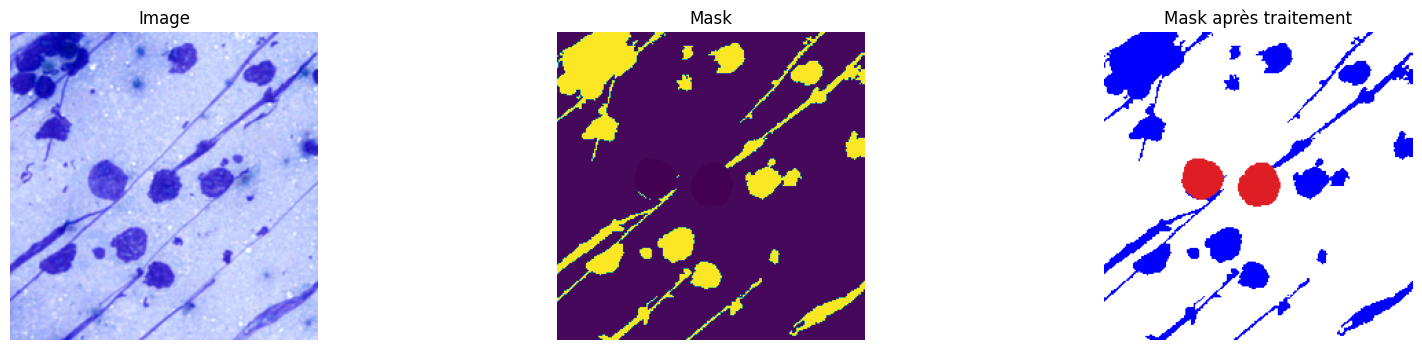

Label: tensor(1)
torch.Size([224, 224])
Couleurs du mask
[ 1  2 44]
Couleurs du mask traitement
[  0  30  36 222 255]


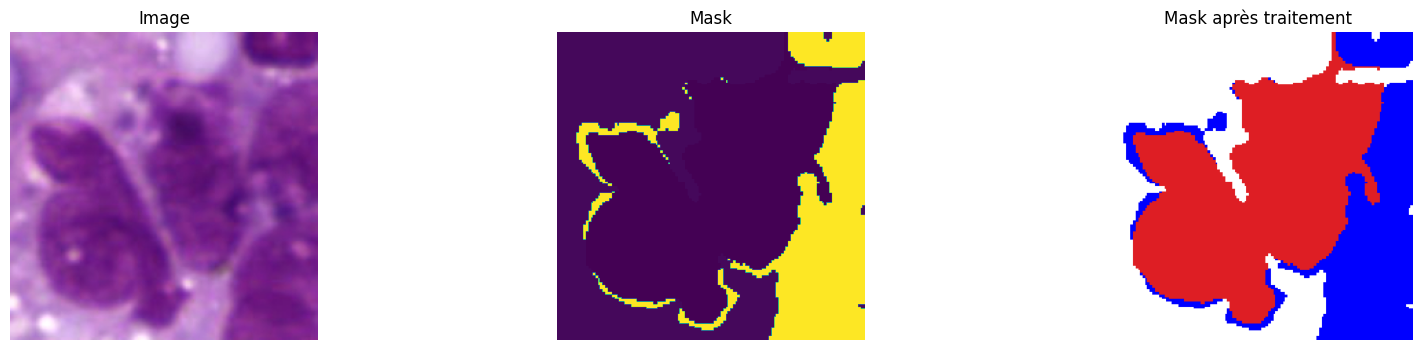

Label: tensor(1)
torch.Size([224, 224])
Couleurs du mask
[ 1  2 44]
Couleurs du mask traitement
[  0  30  36 222 255]


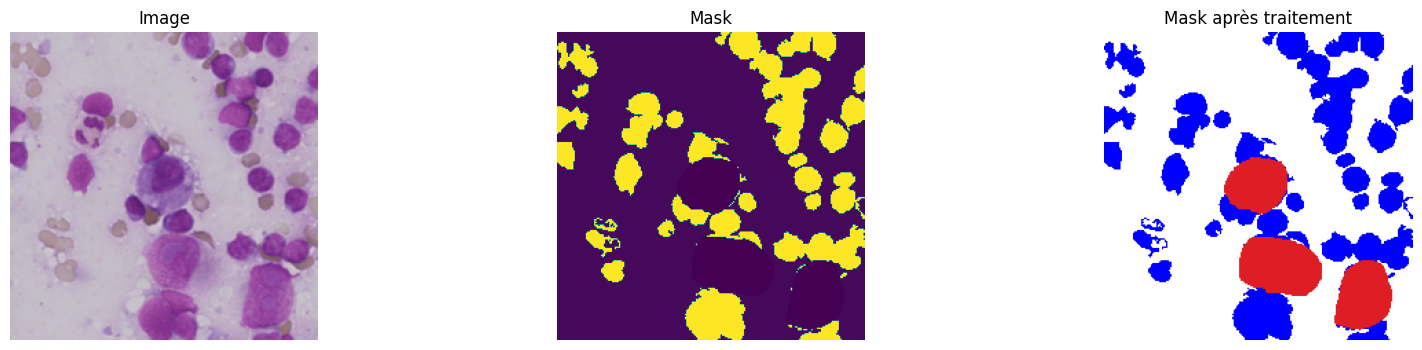

Label: tensor(1)
torch.Size([224, 224])
Couleurs du mask
[ 1  2 44]
Couleurs du mask traitement
[  0  30  36 222 255]


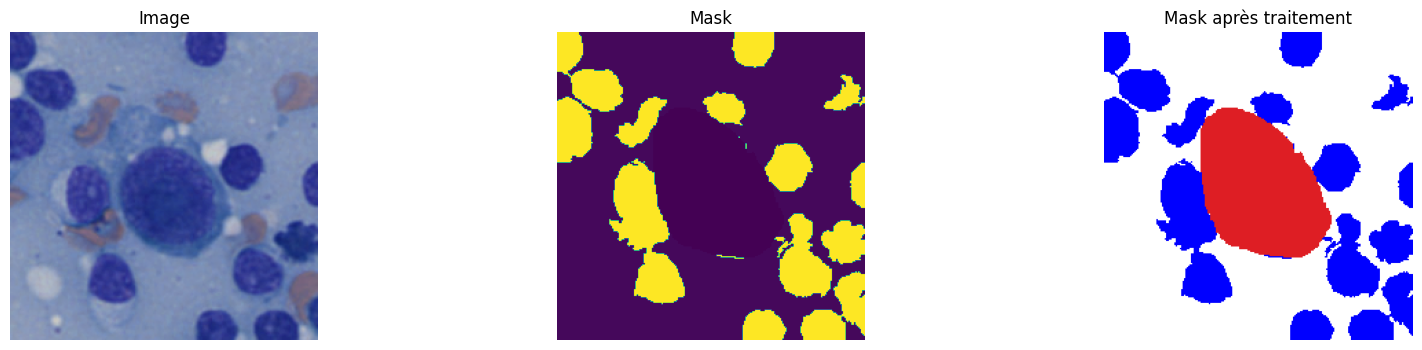

Label: tensor(1)
torch.Size([224, 224])
Couleurs du mask
[ 1  2 44]
Couleurs du mask traitement
[  0  30  36 222 255]


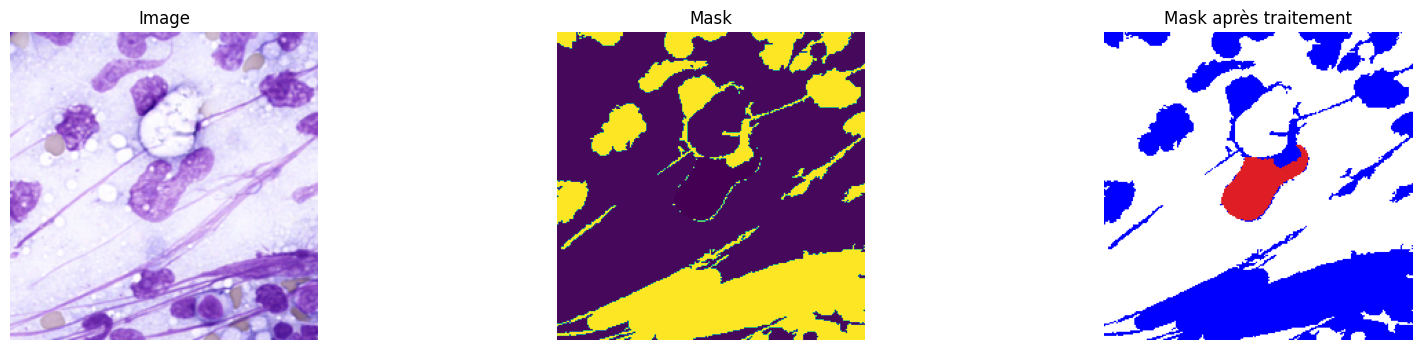

Label: tensor(1)
torch.Size([224, 224])
Couleurs du mask
[ 0  2 44]
Couleurs du mask traitement
[  0  70  96 209 255]


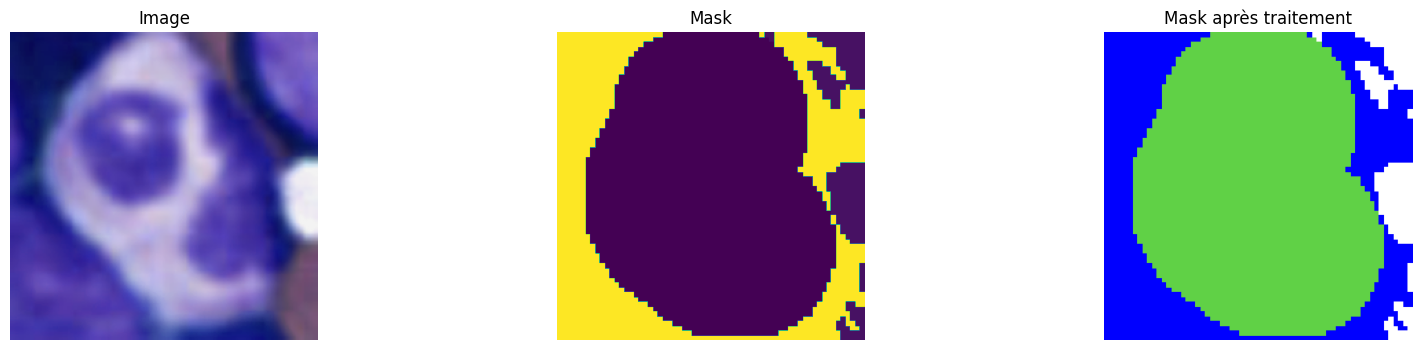

Label: tensor(0)


In [10]:
for i, (image, mask, label) in enumerate(train_loader):
    mask = mask[i].squeeze()
    print(mask.shape)
    print("Couleurs du mask")
    print(np.unique(mask))
    mask_gray_to_rgb = grayscale_to_rgb_mask(mask)
    print("Couleurs du mask traitement")
    print(np.unique(mask_gray_to_rgb))
    show_images([image[i].permute(1, 2, 0), mask, mask_gray_to_rgb], ["Image", "Mask", "Mask après traitement"])
    print("Label:", label[i])
    if i == 5:
        break

### Déclaration du modèle

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Déclaration du modèle UNet++ avec ResNet comme backbone
class UNetPlusPlusResNet(nn.Module):
    def __init__(self, n_classes=8, backbone='resnet50'):
        super(UNetPlusPlusResNet, self).__init__()
        
        # Charger ResNet pré-entraîné
        if backbone == 'resnet50':
            self.encoder = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            enc_channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError("Backbone non supporté: Choisir 'resnet50'")
        
        # Encoder utilisant les couches ResNet
        self.enc1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu)
        self.enc2 = nn.Sequential(self.encoder.maxpool, self.encoder.layer1)
        self.enc3 = self.encoder.layer2
        self.enc4 = self.encoder.layer3
        self.enc5 = self.encoder.layer4
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(enc_channels[-1], 1024, kernel_size=3, padding=1)
        
        # Décodeur avec connexions denses UNet++
        self.up4 = self._up_conv(1024, enc_channels[3])
        self.decoder4 = self.conv_block(enc_channels[3] * 2, enc_channels[3])
        self.up3 = self._up_conv(enc_channels[3], enc_channels[2])
        self.decoder3 = self.conv_block(enc_channels[2] * 2, enc_channels[2])
        self.up2 = self._up_conv(enc_channels[2], enc_channels[1])
        self.decoder2 = self.conv_block(enc_channels[1] * 2, enc_channels[1])
        self.up1 = self._up_conv(enc_channels[1], enc_channels[0])
        self.decoder1 = self.conv_block(enc_channels[0] * 2, enc_channels[0])
        
        # Couche finale pour la segmentation
        self.conv_final = nn.Conv2d(enc_channels[0], n_classes, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _up_conv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        
        bottleneck = self.bottleneck(enc5)
        
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        output = self.conv_final(dec1)
        
        # Correction : Assurer que la sortie est de la même taille que les masques d'entrée
        output = F.interpolate(output, size=(224, 224), mode="bilinear", align_corners=True)
        
        return output

print("Déclaration du modèle")
model = UNetPlusPlusResNet(n_classes=8)
print("Fin de déclaration du modèle")


Déclaration du modèle
Fin de déclaration du modèle


### Entraînement du modèle

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device="cuda", writer=None):
    model.to(device)
    
    best_val_loss = float('inf')
    best_model_wts = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for i, (images, masks, labels) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()

            optimizer.zero_grad()
            outputs = model(images)  # Le modèle retourne les prédictions de segmentation (8 canaux)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Mise à jour de tqdm (Barre de progression)
            train_loader.set_postfix(loss=loss.item())

        # Calcul de la perte moyenne sur l'époque
        epoch_loss = running_loss / len(train_loader)
        if writer:
            writer.add_scalar('Loss/train', epoch_loss, epoch)

        # Validation après chaque époque
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks, labels in val_loader:
                images = images.to(device)
                masks = masks.to(device).squeeze(1).long()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        if writer:
            writer.add_scalar('Loss/validation', val_loss, epoch)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

        # Afficher un exemple de masque généré et le comparer avec le masque original
        if epoch % 1 == 0:
            with torch.no_grad():
                sample_image = images[0].cpu()
                sample_output = outputs[0].cpu()
                sample_mask = masks[0].cpu()

                # Convertir les prédictions en indices de classe (0 à 7)
                predicted_mask = torch.argmax(sample_output, dim=0)  # (H, W)
                predicted_mask_rgb = grayscale_to_rgb_mask(predicted_mask)

                # Convertir l'image PIL en Tensor pour TensorBoard
                predicted_mask_rgb_tensor = TF.to_tensor(predicted_mask_rgb)

                if sample_image.shape[0] == 1:  # Si l'image a une seule dimension
                    sample_image = sample_image.repeat(3, 1, 1)  # Répliquer les canaux pour en avoir 3
                if writer:
                    writer.add_image('Image/Input', sample_image, epoch)  # Image originale
                    writer.add_image('Image/Predicted Mask', predicted_mask_rgb_tensor, epoch)  # Masque prédit
                    writer.add_image('Image/Real Mask', TF.to_tensor(grayscale_to_rgb_mask(sample_mask)), epoch)  # Masque réel

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    if writer:
        writer.close()
        
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    torch.save(model.state_dict(), f"{model_name}_{num_epochs}epochs.pth")
        
    

In [13]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms.functional as TF

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device="cuda", writer=None):
    model.to(device)
    best_val_loss = float('inf')
    best_model_wts = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for images, masks, labels in train_loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()

            optimizer.zero_grad()
            outputs = model(images)  # U-Net++ retourne les prédictions de segmentation
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_loader.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_loader)
        if writer:
            writer.add_scalar('Loss/train', epoch_loss, epoch)
        
        # Validation après chaque époque
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks, labels in val_loader:
                images = images.to(device)
                masks = masks.to(device).squeeze(1).long()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        if writer:
            writer.add_scalar('Loss/validation', val_loss, epoch)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
        
        # Afficher un exemple de masque généré
        if epoch % 1 == 0:
            with torch.no_grad():
                sample_image = images[0].cpu()
                sample_output = outputs[0].cpu()
                sample_mask = masks[0].cpu()

                predicted_mask = torch.argmax(sample_output, dim=0)  # (H, W)
                predicted_mask_rgb = grayscale_to_rgb_mask(predicted_mask)
                predicted_mask_rgb_tensor = TF.to_tensor(predicted_mask_rgb)

                if sample_image.shape[0] == 1:
                    sample_image = sample_image.repeat(3, 1, 1)
                if writer:
                    writer.add_image('Image/Input', sample_image, epoch)
                    writer.add_image('Image/Predicted Mask', predicted_mask_rgb_tensor, epoch)
                    writer.add_image('Image/Real Mask', TF.to_tensor(grayscale_to_rgb_mask(sample_mask)), epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    if writer:
        writer.close()
    
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    torch.save(model.state_dict(), f"{model.__class__.__name__}_{num_epochs}epochs.pth")


In [14]:
import torch
import numpy as np
from PIL import Image

def compute_class_weights_from_masks(dataset, num_classes=8):
    class_counts = torch.zeros(num_classes)  # Un compteur pour chaque classe de segmentation
    
    for _, mask_path, _ in dataset:  # Parcourir le dataset
        mask = Image.open(mask_path)  # Ouvrir le masque
        mask_np = np.array(mask)  # Convertir le masque en numpy array
        mask_index = rgb_to_grayscale_mask(mask_np)
        mask_index = np.array(mask_index)
        
        # Compter les occurrences de chaque classe dans le masque
        for class_idx in range(num_classes):
            class_counts[class_idx] += np.sum(mask_index == class_idx)
    
    total_samples = class_counts.sum().item()
    
    # Inverser la proportion pour donner plus de poids aux classes minoritaires
    class_weights = total_samples / (class_counts + 1e-6)  # Ajouter une petite valeur pour éviter la division par zéro
    
    return class_weights.to(torch.float32)

# Calculer les poids pour les classes de segmentation dans le dataset d'entraînement
# class_weights = compute_class_weights_from_masks(train_data, num_classes=8).to(device)

# print(f"Pondérations des classes de segmentation: {class_weights}")


In [15]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Déclaration du modèle UNet++ avec ResNet comme backbone
print("Déclaration du modèle")
model = UNetPlusPlusResNet(n_classes=3)
print("Fin de déclaration du modèle")

# Définition de la fonction de perte
criterion = nn.CrossEntropyLoss(ignore_index=44)
# criterion = MaskedCELoss()  # Option alternative si nécessaire

# Définition de l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Nombre d'époques
num_epochs = 30

# Configuration de TensorBoard
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(log_dir=f"runs/{model.__class__.__name__}_{num_epochs}epochs_{current_date}")

# Lancer l'entraînement
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, writer=writer)


Déclaration du modèle
Fin de déclaration du modèle


Epoch 1/30: 100%|██████████| 1511/1511 [22:13<00:00,  1.13batch/s, loss=0.332]


Epoch 1/30, Train Loss: 0.4760, Validation Loss: 0.4696


Epoch 2/30: 100%|██████████| 1511/1511 [11:01<00:00,  2.28batch/s, loss=0.356]


Epoch 2/30, Train Loss: 0.4213, Validation Loss: 0.4942


Epoch 3/30: 100%|██████████| 1511/1511 [10:40<00:00,  2.36batch/s, loss=0.332]


Epoch 3/30, Train Loss: 0.3982, Validation Loss: 0.3653


Epoch 4/30: 100%|██████████| 1511/1511 [10:39<00:00,  2.36batch/s, loss=0.443]


Epoch 4/30, Train Loss: 0.3855, Validation Loss: 0.3500


Epoch 5/30: 100%|██████████| 1511/1511 [11:09<00:00,  2.26batch/s, loss=0.205]


Epoch 5/30, Train Loss: 0.3673, Validation Loss: 0.3577


Epoch 6/30: 100%|██████████| 1511/1511 [11:07<00:00,  2.26batch/s, loss=0.213]


Epoch 6/30, Train Loss: 0.3641, Validation Loss: 0.3435


Epoch 7/30: 100%|██████████| 1511/1511 [11:05<00:00,  2.27batch/s, loss=0.23] 


Epoch 7/30, Train Loss: 0.3538, Validation Loss: 0.3545


Epoch 8/30: 100%|██████████| 1511/1511 [10:55<00:00,  2.30batch/s, loss=0.216] 


Epoch 8/30, Train Loss: 0.3462, Validation Loss: 0.3205


Epoch 9/30: 100%|██████████| 1511/1511 [11:04<00:00,  2.27batch/s, loss=0.219]


Epoch 9/30, Train Loss: 0.3418, Validation Loss: 0.3255


Epoch 10/30: 100%|██████████| 1511/1511 [11:05<00:00,  2.27batch/s, loss=0.372] 


Epoch 10/30, Train Loss: 0.3366, Validation Loss: 0.3182


Epoch 11/30: 100%|██████████| 1511/1511 [11:06<00:00,  2.27batch/s, loss=0.232] 


Epoch 11/30, Train Loss: 0.3309, Validation Loss: 0.3380


Epoch 12/30: 100%|██████████| 1511/1511 [11:08<00:00,  2.26batch/s, loss=0.157] 


Epoch 12/30, Train Loss: 0.3285, Validation Loss: 0.3249


Epoch 13/30: 100%|██████████| 1511/1511 [11:09<00:00,  2.26batch/s, loss=0.328]


Epoch 13/30, Train Loss: 0.3258, Validation Loss: 0.3288


Epoch 14/30: 100%|██████████| 1511/1511 [10:51<00:00,  2.32batch/s, loss=0.65] 


Epoch 14/30, Train Loss: 0.3219, Validation Loss: 0.3205


Epoch 15/30: 100%|██████████| 1511/1511 [10:38<00:00,  2.37batch/s, loss=0.19]  


Epoch 15/30, Train Loss: 0.3199, Validation Loss: 0.3230


Epoch 16/30: 100%|██████████| 1511/1511 [11:01<00:00,  2.28batch/s, loss=0.314] 


Epoch 16/30, Train Loss: 0.3175, Validation Loss: 0.2996


Epoch 17/30: 100%|██████████| 1511/1511 [10:58<00:00,  2.30batch/s, loss=0.403] 


Epoch 17/30, Train Loss: 0.3118, Validation Loss: 0.3137


Epoch 18/30: 100%|██████████| 1511/1511 [10:58<00:00,  2.30batch/s, loss=0.594] 


Epoch 18/30, Train Loss: 0.3076, Validation Loss: 0.3220


Epoch 19/30: 100%|██████████| 1511/1511 [10:56<00:00,  2.30batch/s, loss=0.113] 


Epoch 19/30, Train Loss: 0.3091, Validation Loss: 0.2936


Epoch 20/30: 100%|██████████| 1511/1511 [10:35<00:00,  2.38batch/s, loss=0.167] 


Epoch 20/30, Train Loss: 0.3022, Validation Loss: 0.3210


Epoch 21/30: 100%|██████████| 1511/1511 [11:21<00:00,  2.22batch/s, loss=0.195] 


Epoch 21/30, Train Loss: 0.3029, Validation Loss: 0.2968


Epoch 22/30: 100%|██████████| 1511/1511 [11:21<00:00,  2.22batch/s, loss=0.14]  


Epoch 22/30, Train Loss: 0.3009, Validation Loss: 0.3027


Epoch 23/30: 100%|██████████| 1511/1511 [11:16<00:00,  2.23batch/s, loss=0.121] 


Epoch 23/30, Train Loss: 0.2957, Validation Loss: 0.3231


Epoch 24/30: 100%|██████████| 1511/1511 [10:55<00:00,  2.31batch/s, loss=0.189] 


Epoch 24/30, Train Loss: 0.2952, Validation Loss: 0.2883


Epoch 25/30: 100%|██████████| 1511/1511 [11:10<00:00,  2.25batch/s, loss=0.22]  


Epoch 25/30, Train Loss: 0.2937, Validation Loss: 0.2976


Epoch 26/30: 100%|██████████| 1511/1511 [10:55<00:00,  2.30batch/s, loss=0.521] 


Epoch 26/30, Train Loss: 0.2915, Validation Loss: 0.2908


Epoch 27/30: 100%|██████████| 1511/1511 [10:51<00:00,  2.32batch/s, loss=0.212] 


Epoch 27/30, Train Loss: 0.2880, Validation Loss: 0.2909


Epoch 28/30: 100%|██████████| 1511/1511 [10:59<00:00,  2.29batch/s, loss=0.398] 


Epoch 28/30, Train Loss: 0.2880, Validation Loss: 0.2949


Epoch 29/30: 100%|██████████| 1511/1511 [11:22<00:00,  2.21batch/s, loss=0.267] 


Epoch 29/30, Train Loss: 0.2843, Validation Loss: 0.2966


Epoch 30/30: 100%|██████████| 1511/1511 [11:01<00:00,  2.28batch/s, loss=0.326] 


Epoch 30/30, Train Loss: 0.2824, Validation Loss: 0.2892


In [16]:
torch.save(model.state_dict(), f"{model.__class__.__name__}_{num_epochs}epochs_{current_date}.pth")

### Test du modèle

In [ ]:
# Charger le modèle UNet++ avec ResNet
model = UNetPlusPlusResNet(n_classes=3)
model.to(device)
model.load_state_dict(torch.load("UNetPlusPlusResNet_30epochs.pth"))


In [21]:
def test_model(model, test_loader, criterion, num_images_to_show=5, device="cuda"):
    model.eval()
    
    all_labels = []
    all_predictions = []
    running_loss = 0.0
    random_indices = random.sample(range(len(test_loader.dataset)), num_images_to_show)
    
    with torch.no_grad():
        test_loader = tqdm(test_loader, desc="Testing", unit="batch")
        
        for batch_idx, (images, masks, labels) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            # Appliquer le modèle
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            # Convertir les prédictions en indices de classes par pixel
            predicted_masks = torch.argmax(outputs, dim=1).cpu()  # (batch_size, H, W)
            
            for i in range(len(images)):  # Parcours de chaque image du batch
                input_image = images[i].cpu().permute(1, 2, 0)  # Convertir pour affichage (H, W, C)
                true_mask = masks[i].cpu().squeeze(0)  # Masque de vérité terrain (H, W)
                predicted_mask = predicted_masks[i]  # Masque prédit (H, W)
                label = labels[i].item()  # Label de l'image (0 ou 1)
                
                # Masque des parties annotées (ici on suppose que la classe 44 correspond à des zones non annotées)
                annotated_mask = true_mask != 44  # Ignorer les pixels de la classe 44 (non annotée)
                
                # Filtrer les zones non annotées dans le masque de vérité et les prédictions
                true_mask_filtered = true_mask[annotated_mask]
                predicted_mask_filtered = predicted_mask[annotated_mask]
                
                # Vérifier si la prédiction contient des pixels tumoraux dans les zones annotées (classes 1 => tumorale)
                tumor_detected = torch.any((predicted_mask_filtered == 1)).item()
                prediction = 1 if tumor_detected else 0
                
                all_labels.append(label)
                all_predictions.append(prediction)
                
                # Affichage des images aléatoires
                if batch_idx * len(images) + i in random_indices:
                    true_mask_rgb = grayscale_to_rgb_mask(true_mask)
                    predicted_mask_rgb = grayscale_to_rgb_mask(predicted_mask)

                    # Afficher les images
                    show_images(
                        [input_image, true_mask_rgb, predicted_mask_rgb],
                        ["Image originale", "Masque de vérité terrain", "Masque prédit par le modèle"]
                    )

        # Calcul de la loss moyenne sur l'ensemble du dataset
        avg_loss = running_loss / len(test_loader)

        # Calcul des métriques
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions)
        
        print("----------------------------------------------")

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Test Loss: {avg_loss:.4f}")
        
        accuracy_balanced = accuracy_score(all_labels, all_predictions)
        precision_balanced = precision_score(all_labels, all_predictions, average='weighted')
        recall_balanced = recall_score(all_labels, all_predictions, average='weighted')
        
        print("----------------------------------------------")
        
        print(f"Balanced Accuracy: {accuracy_balanced:.4f}")
        print(f"Balanced Precision: {precision_balanced:.4f}")
        print(f"Balanced Recall: {recall_balanced:.4f}")
        
        print("----------------------------------------------")

        # Afficher la matrice de confusion
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sain', 'Tumoral'], yticklabels=['Sain', 'Tumoral'])
        plt.xlabel('Prédictions')
        plt.ylabel('Vérités terrain')
        plt.title('Matrice de Confusion')
        plt.show()

In [22]:
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_curve, auc, confusion_matrix

def dice_score(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection) / (torch.sum(y_true) + torch.sum(y_pred) + 1e-6)

def test_model(model, test_loader, criterion, num_images_to_show=5, device="cuda"):
    model.eval()
    
    all_labels = []
    all_predictions = []
    all_dice_scores = []
    all_probs = []
    running_loss = 0.0
    random_indices = random.sample(range(len(test_loader.dataset)), num_images_to_show)
    
    with torch.no_grad():
        test_loader = tqdm(test_loader, desc="Testing", unit="batch")
        
        for batch_idx, (images, masks, labels) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()
            labels = labels.to(device)
            
            # Appliquer le modèle
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[1:], mode="bilinear", align_corners=True)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            # Convertir les prédictions en indices de classes par pixel
            predicted_masks = torch.argmax(outputs, dim=1).cpu()
            predicted_probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            
            for i in range(len(images)):
                input_image = images[i].cpu().permute(1, 2, 0)
                true_mask = masks[i].cpu()
                predicted_mask = predicted_masks[i]
                label = labels[i].item()
                
                annotated_mask = true_mask != 44
                true_mask_filtered = true_mask[annotated_mask]
                predicted_mask_filtered = predicted_mask[annotated_mask]
                
                tumor_detected = torch.any((predicted_mask_filtered == 1)).item()
                prediction = 1 if tumor_detected else 0
                
                all_labels.append(label)
                all_predictions.append(prediction)
                all_probs.append(predicted_probs[i])
                
                dice = dice_score(true_mask_filtered.float(), predicted_mask_filtered.float())
                all_dice_scores.append(dice.item())
                
                if batch_idx * len(images) + i in random_indices:
                    true_mask_rgb = grayscale_to_rgb_mask(true_mask)
                    predicted_mask_rgb = grayscale_to_rgb_mask(predicted_mask)

                    show_images(
                        [input_image, true_mask_rgb, predicted_mask_rgb],
                        ["Image originale", "Masque de vérité terrain", "Masque prédit par le modèle"]
                    )
        
        avg_loss = running_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)
        iou = jaccard_score(all_labels, all_predictions)
        dice_mean = sum(all_dice_scores) / len(all_dice_scores)
        
        print("----------------------------------------------")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"IoU (Intersection over Union): {iou:.4f}")
        print(f"Dice Score: {dice_mean:.4f}")
        print(f"Test Loss: {avg_loss:.4f}")
        
        precision_balanced = precision_score(all_labels, all_predictions, average='weighted')
        recall_balanced = recall_score(all_labels, all_predictions, average='weighted')
        f1_balanced = f1_score(all_labels, all_predictions, average='weighted')
        iou_balanced = jaccard_score(all_labels, all_predictions, average='weighted')
        
        print("----------------------------------------------")
        print(f"Balanced Precision: {precision_balanced:.4f}")
        print(f"Balanced Recall: {recall_balanced:.4f}")
        print(f"Balanced F1-Score: {f1_balanced:.4f}")
        print(f"Balanced IoU: {iou_balanced:.4f}")
        print("----------------------------------------------")

        conf_matrix = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sain', 'Tumoral'], yticklabels=['Sain', 'Tumoral'])
        plt.xlabel('Prédictions')
        plt.ylabel('Vérités terrain')
        plt.title('Matrice de Confusion')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Learning Curves
        plt.figure()
        plt.plot(range(1, len(all_dice_scores)+1), all_dice_scores, label='Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Learning Curve')
        plt.legend()
        plt.show()


Testing:   4%|▍         | 8/204 [00:03<01:21,  2.39batch/s]

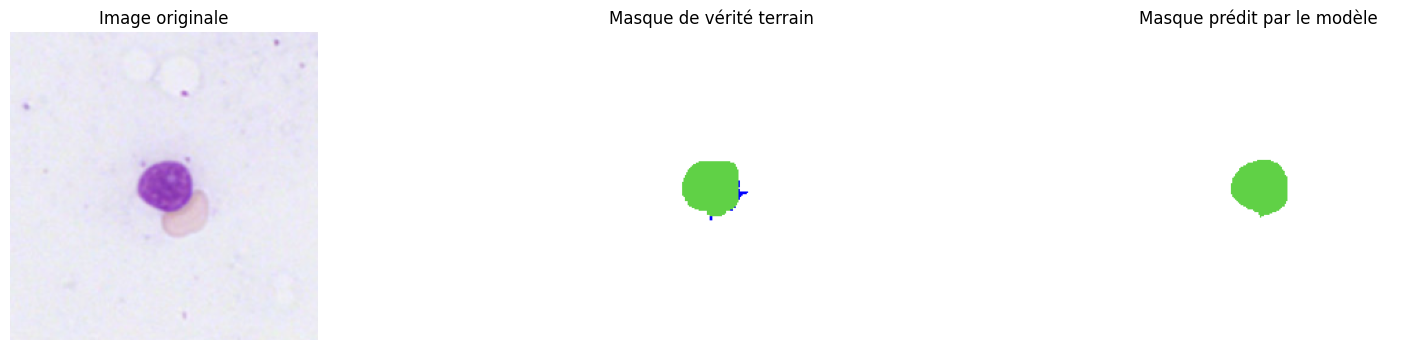

Testing:  10%|█         | 21/204 [00:08<01:12,  2.51batch/s]

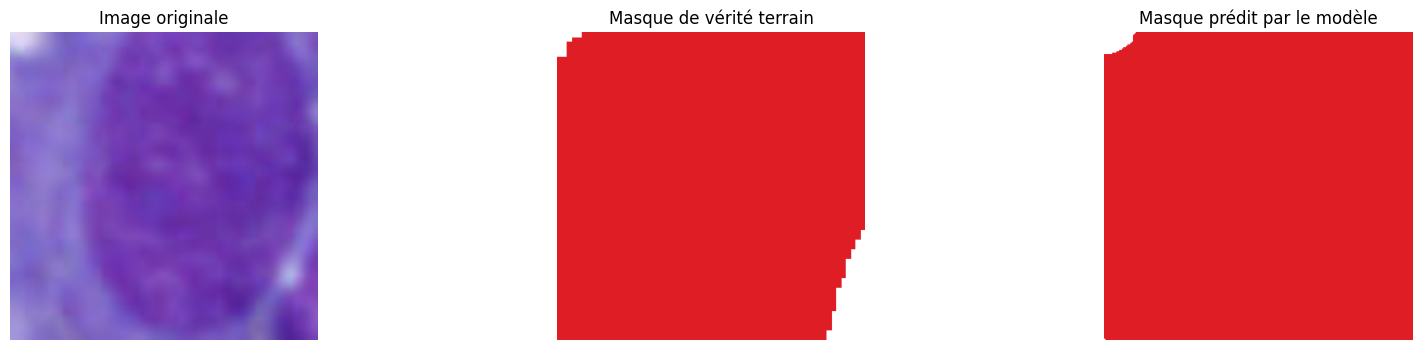

Testing:  13%|█▎        | 27/204 [00:10<01:04,  2.76batch/s]

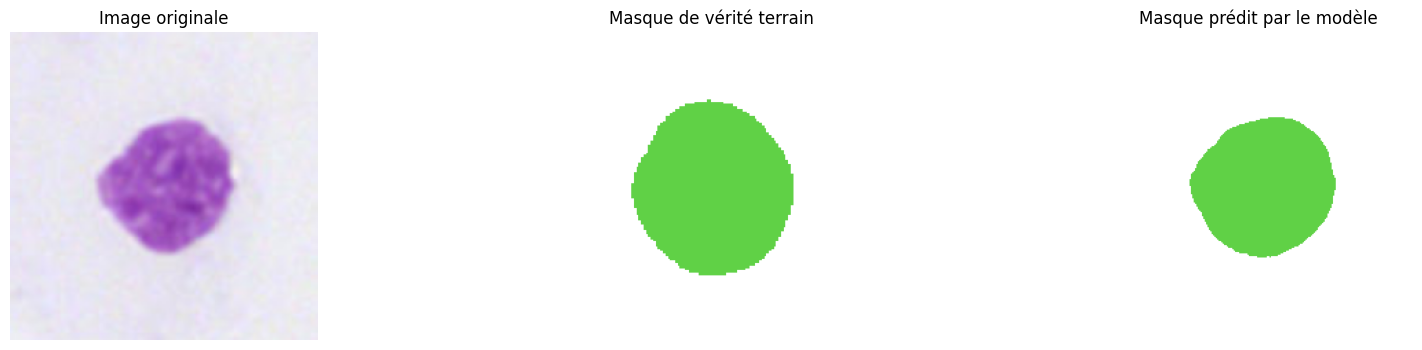

Testing:  17%|█▋        | 34/204 [00:13<00:58,  2.91batch/s]

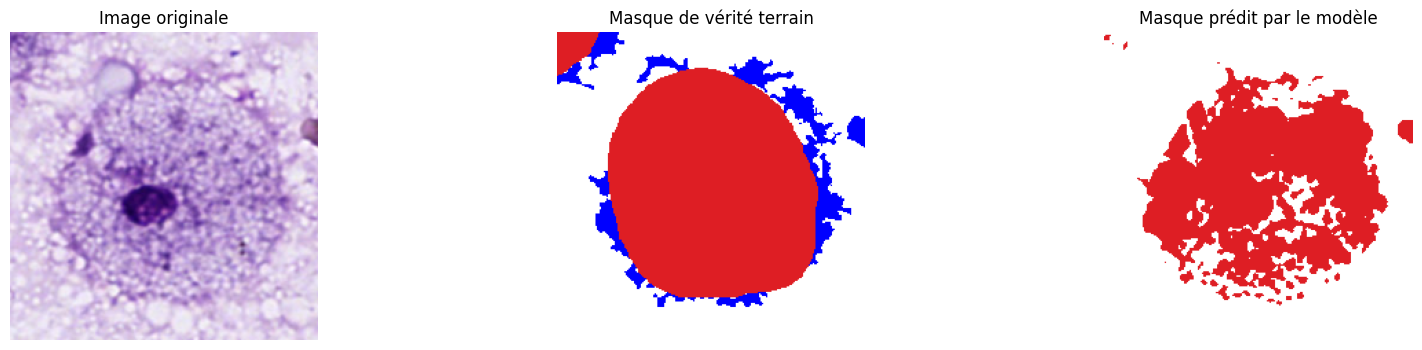

Testing:  21%|██        | 43/204 [00:17<01:05,  2.45batch/s]

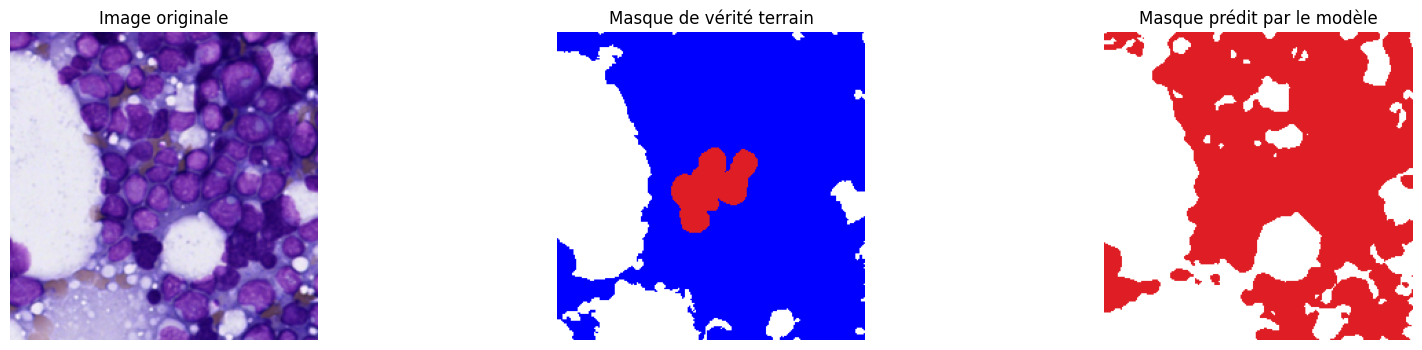

Testing:  37%|███▋      | 76/204 [00:31<00:52,  2.46batch/s]

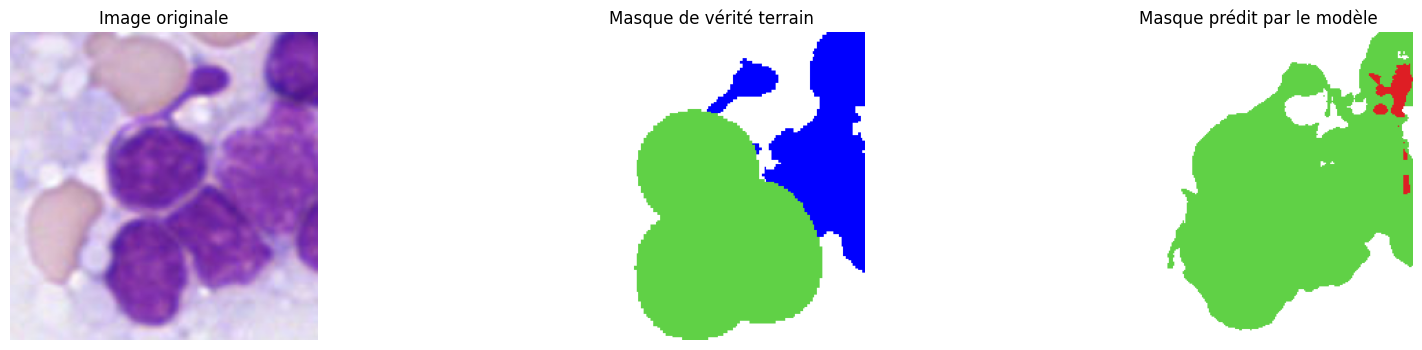

Testing:  38%|███▊      | 77/204 [00:31<00:55,  2.28batch/s]

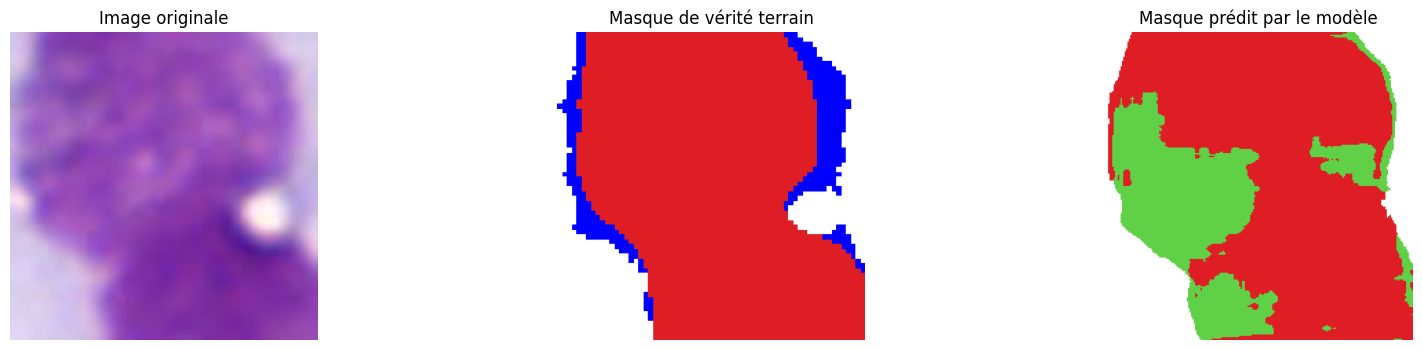

Testing:  40%|███▉      | 81/204 [00:33<00:50,  2.44batch/s]

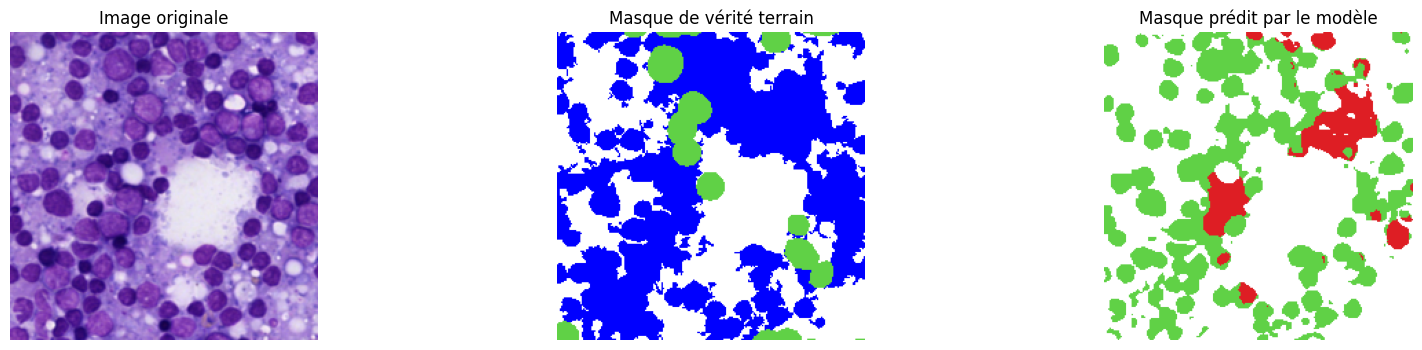

Testing:  41%|████      | 83/204 [00:35<01:15,  1.60batch/s]

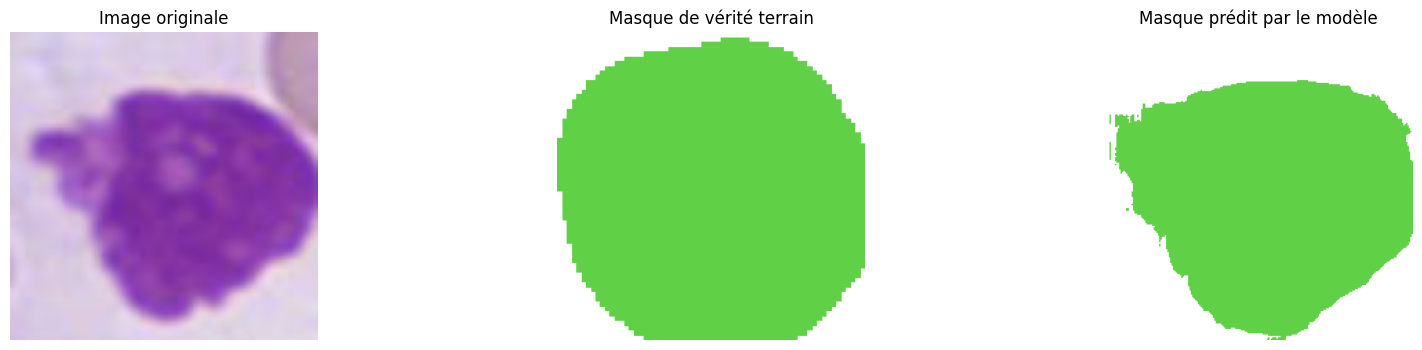

Testing:  44%|████▎     | 89/204 [00:37<00:50,  2.29batch/s]

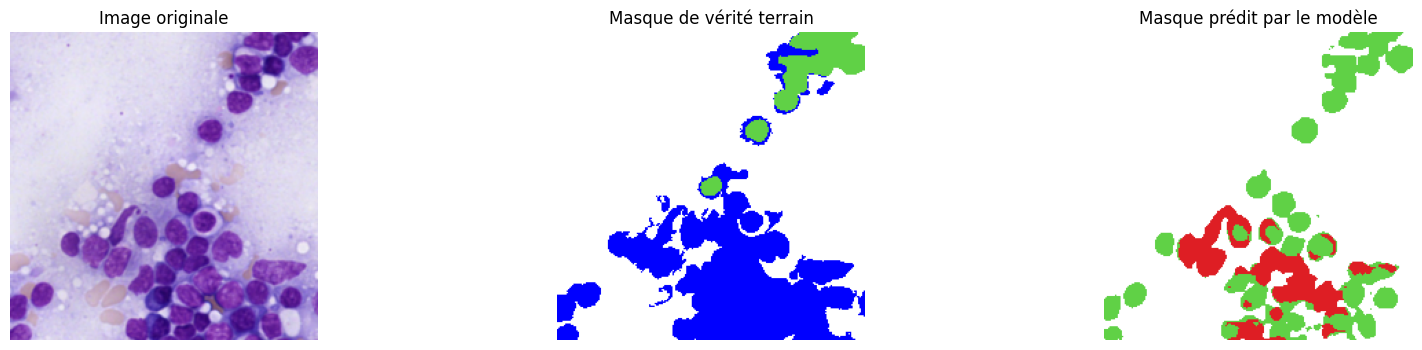

Testing:  53%|█████▎    | 108/204 [00:45<00:34,  2.75batch/s]

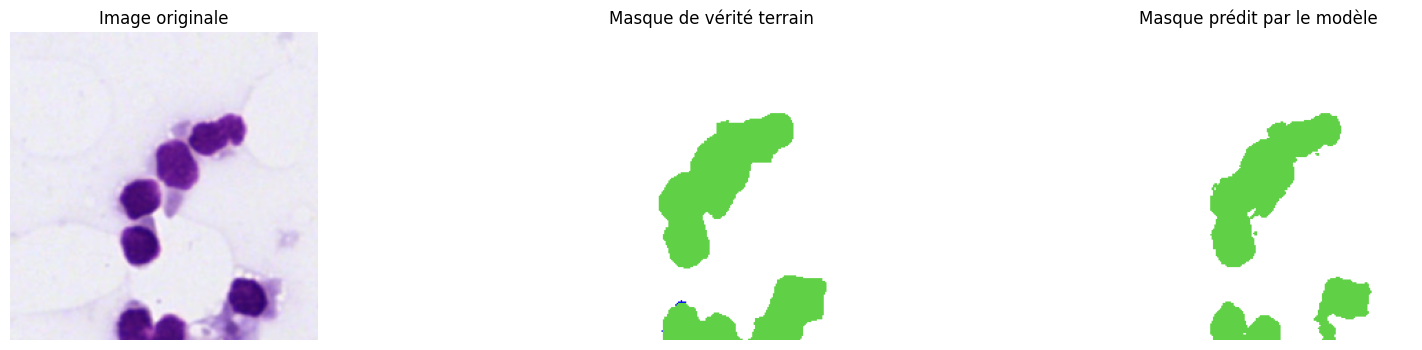

Testing:  53%|█████▎    | 109/204 [00:46<00:45,  2.07batch/s]

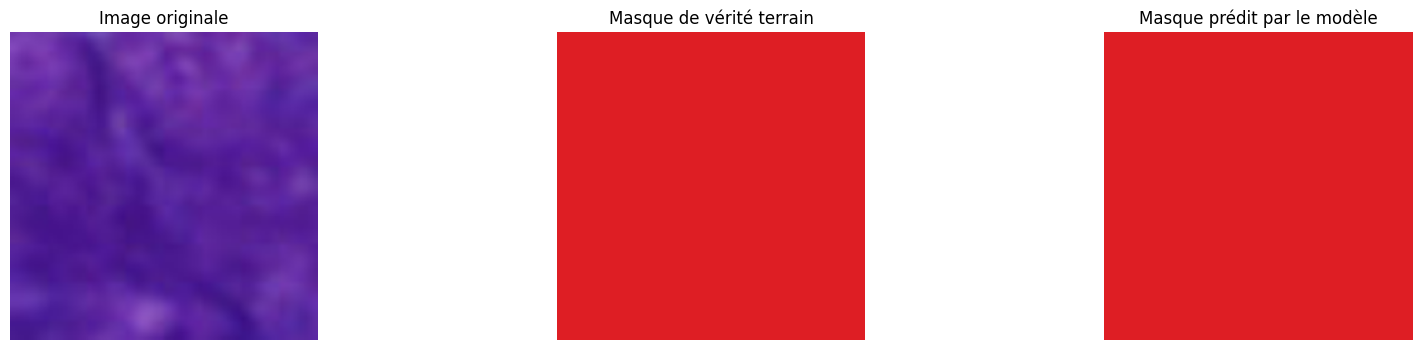

Testing:  55%|█████▍    | 112/204 [00:47<00:42,  2.18batch/s]

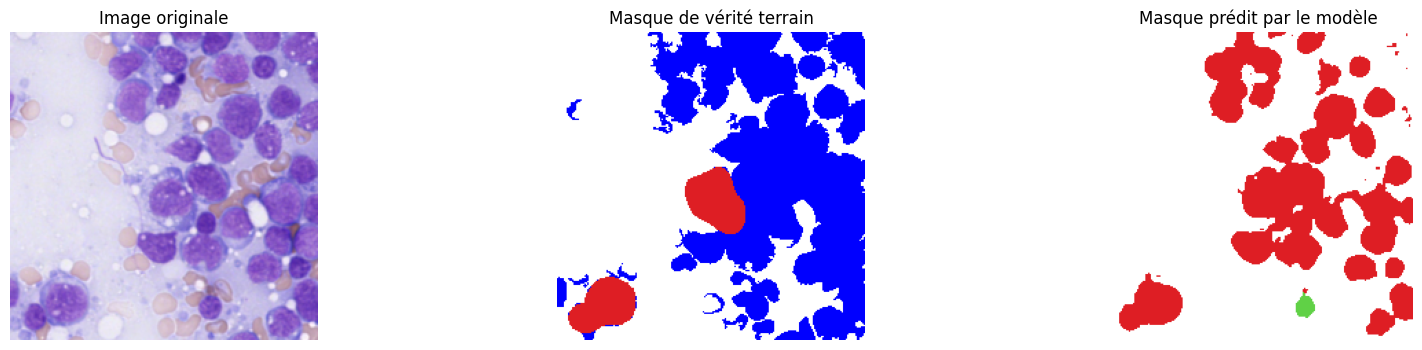

Testing:  59%|█████▉    | 120/204 [00:50<00:23,  3.53batch/s]

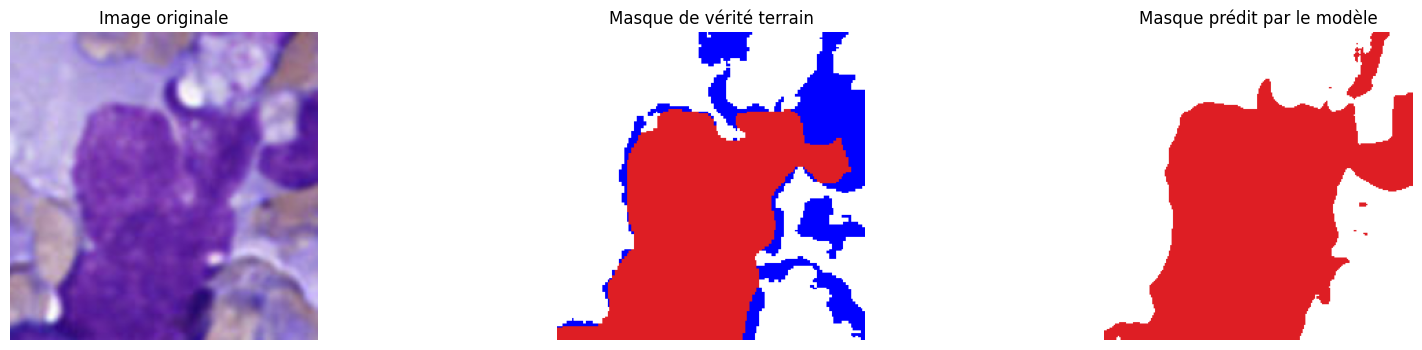

Testing:  71%|███████   | 144/204 [00:59<00:27,  2.14batch/s]

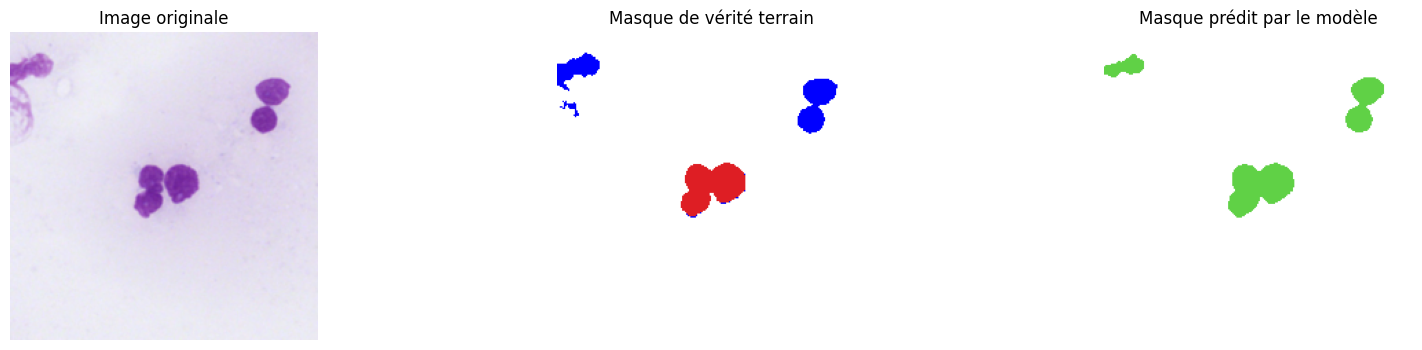

Testing:  75%|███████▌  | 154/204 [01:02<00:15,  3.13batch/s]

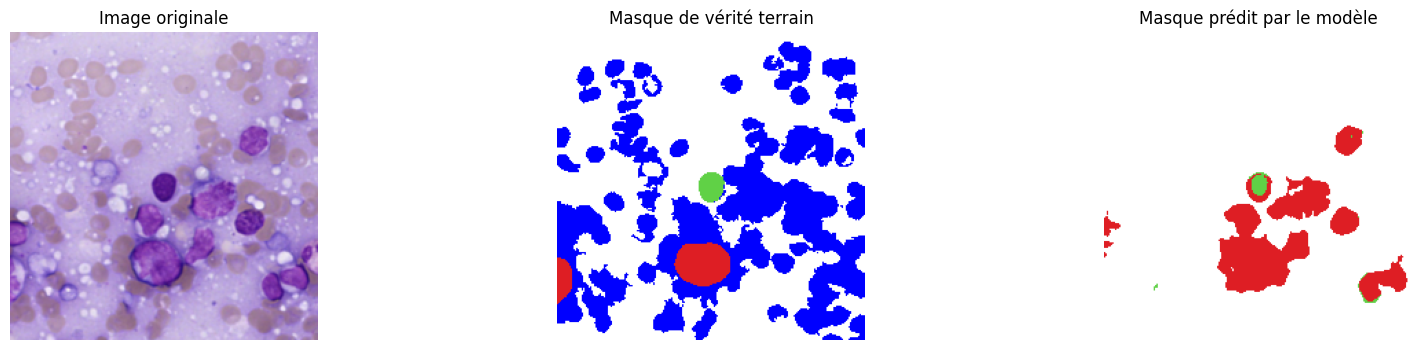

Testing:  80%|████████  | 164/204 [01:07<00:15,  2.61batch/s]

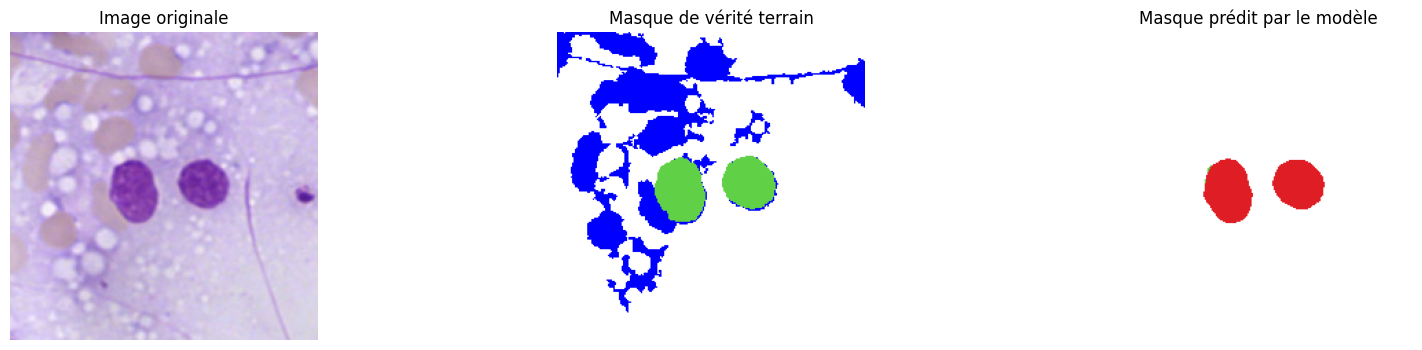

Testing:  87%|████████▋ | 177/204 [01:13<00:11,  2.30batch/s]

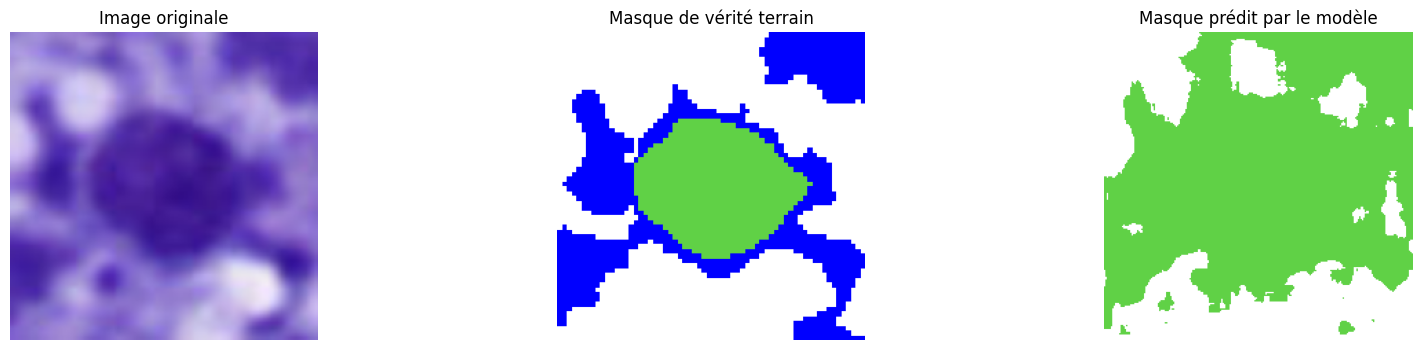

Testing:  88%|████████▊ | 179/204 [01:14<00:12,  1.96batch/s]

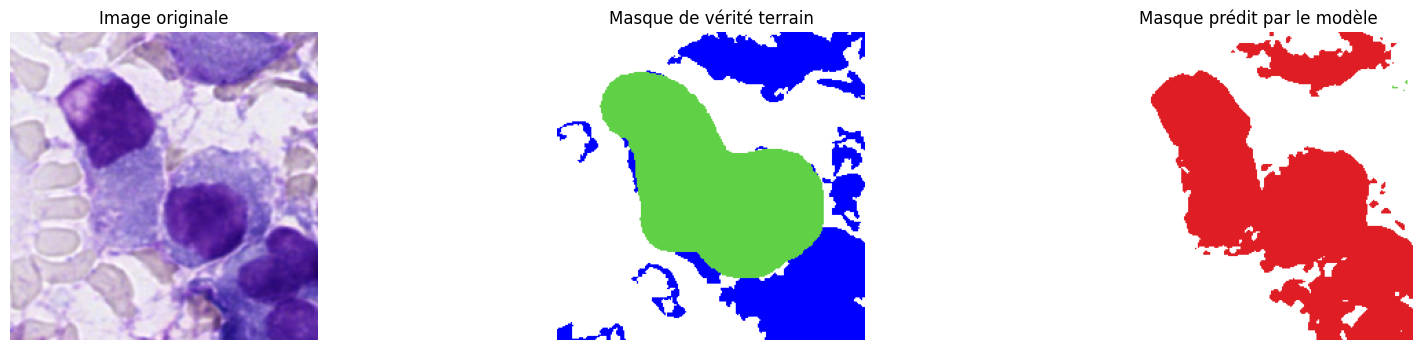

Testing:  98%|█████████▊| 199/204 [01:23<00:02,  2.24batch/s]

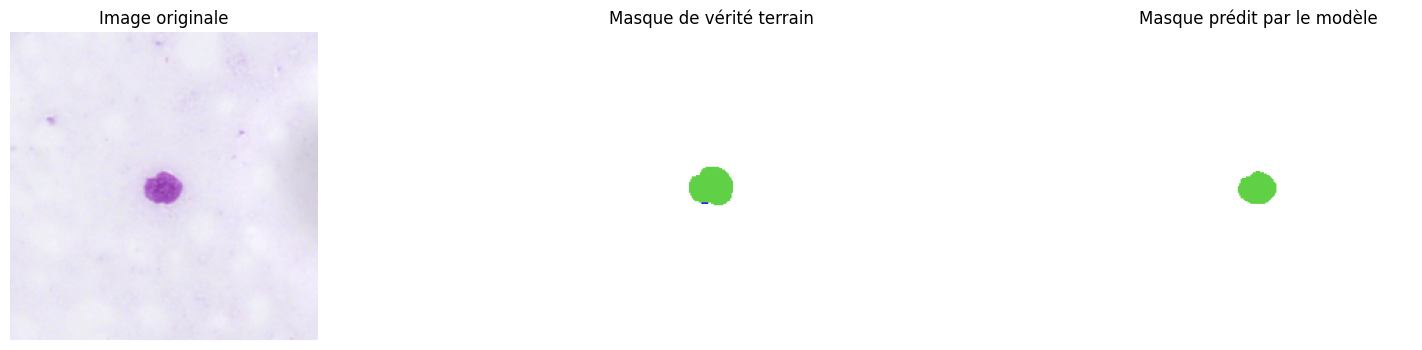

Testing: 100%|██████████| 204/204 [01:24<00:00,  2.40batch/s]

----------------------------------------------
Accuracy: 0.7465
Precision: 0.6629
Recall: 0.9259
F1-Score: 0.7726
IoU (Intersection over Union): 0.6295
Dice Score: 1.6855
Test Loss: 0.2841
----------------------------------------------
Balanced Precision: 0.7905
Balanced Recall: 0.7465
Balanced F1-Score: 0.7410
Balanced IoU: 0.5894
----------------------------------------------


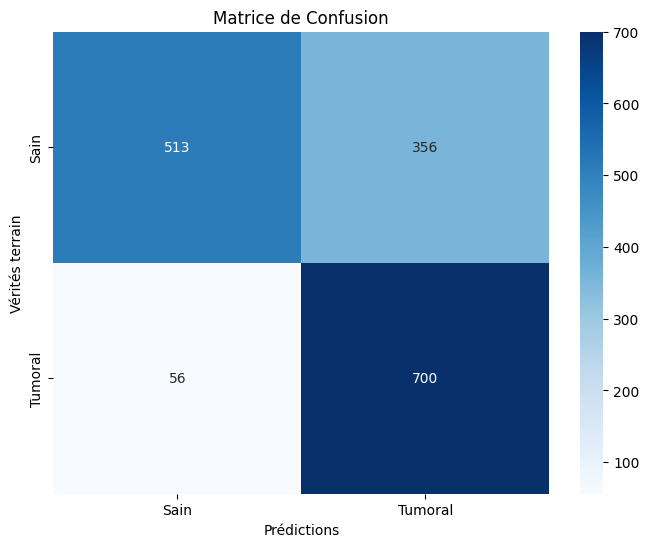

ValueError: Found array with dim 3. None expected <= 2.

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index=44)
test_model(model, test_loader, criterion, num_images_to_show=20, device=device)

In [27]:
# COURBE DE PERTE POUR DEEPLABV3
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss vs Validation loss')
    plt.legend()
    plt.show()

# CALCUL DES MÉTRIQUES AVANCÉES POUR DEEPLABV3
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, jaccard_score, confusion_matrix, precision_score, recall_score
from medpy.metric.binary import dc, hd, assd

import numpy as np

import numpy as np
from sklearn.metrics import accuracy_score

def calculate_advanced_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()
    
    metrics = {
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Sensitivity': recall_score(y_true, y_pred),
        'Specificity': tn / (tn + fp),
        'Precision': precision_score(y_true, y_pred),
        'Jaccard': jaccard_score(y_true, y_pred),
        'F-measure': f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Sensitivity': recall_score(y_true, y_pred),
        'Specificity': recall_score(y_true, y_pred, pos_label=0),
        'Precision': precision_score(y_true, y_pred),
        'Jaccard': jaccard_score(y_true, y_pred),
        'F-measure': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred),
        'Dice': f1_score(y_true, y_pred),
        'IoU': jaccard_score(y_true, y_pred),
        'Coverage Similarity': (tp + tn) / (tp + tn + fp + fn),
        'Surface Dice Score (SDS)': dc(y_pred, y_true),
        'Volume Similarity (VS)': abs((tp + fn) - (tp + fp)) / max(tp + fn, tp + fp),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        'Boundary F1 Score (BF-score)': f1_score(y_true, y_pred),
        'Mean Surface Distance (MSD)': assd(y_pred, y_true),
        'Average Symmetric Surface Distance (ASSD)': assd(y_pred, y_true),
        'Hausdorff Distance (HD)': hd(y_pred, y_true),
        'G-mean': (tp / (tp + fn)) * (tn / (tn + fp)),
        'False Negative Rate (FNR)': fn / (fn + tp),
        'False Discovery Rate (FDR)': fp / (fp + tp)
    }
    return metrics

# ÉVALUATION DU MODÈLE DEEPLABV3
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1)
        predicted_masks = torch.argmax(outputs, dim=1).cpu()
        
        for i in range(len(images)):
            predicted_mask = predicted_masks[i]
            label = labels[i].item()
            tumor_detected = torch.any(predicted_mask == 1).item()
            prediction = 1 if tumor_detected else 0
            
            all_labels.append(label)
            all_predictions.append(prediction)

# CALCUL DES MÉTRIQUES
metrics_results = calculate_advanced_metrics(all_labels, all_predictions)
for metric, value in metrics_results.items():
    print(f"{metric}: {value:.4f}")

#  AFFICHAGE DE LA COURBE DE PERTE (REMPLACE AVEC LES LISTES RÉELLES)
# plot_loss_curve(train_loss_list, val_loss_list)


Accuracy: 0.7120
Sensitivity: 0.9405
Specificity: 0.5132
Precision: 0.6270
Jaccard: 0.6031
F-measure: 0.7524
AUC: 0.7269
Dice: 0.7524
IoU: 0.6031
Coverage Similarity: 0.7120
Surface Dice Score (SDS): 0.7524
Volume Similarity (VS): 0.3333
Cohen's Kappa: 0.4394
Boundary F1 Score (BF-score): 0.7524
Mean Surface Distance (MSD): 0.7074
Average Symmetric Surface Distance (ASSD): 0.7074
Hausdorff Distance (HD): 9.0000
G-mean: 0.4827
False Negative Rate (FNR): 0.0595
False Discovery Rate (FDR): 0.3730


In [29]:
from tensorboard.backend.event_processing import event_accumulator

# Remplace par le chemin vers ton dossier de logs
log_dir = "runs/UNetPlusPlusResNet_30epochs_2025-02-21_18-59-26/events.out.tfevents.1740160766.c23hpda1.941724.0"

# Charger les événements TensorBoard
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# Extraire les pertes d'entraînement et de validation
train_loss_list = [scalar.value for scalar in ea.Scalars('Loss/train')]
val_loss_list = [scalar.value for scalar in ea.Scalars('Loss/validation')]

# Vérifier les longueurs des listes extraites
print(f"Longueur des pertes d'entraînement : {len(train_loss_list)}")
print(f"Longueur des pertes de validation : {len(val_loss_list)}")

Longueur des pertes d'entraînement : 30
Longueur des pertes de validation : 30


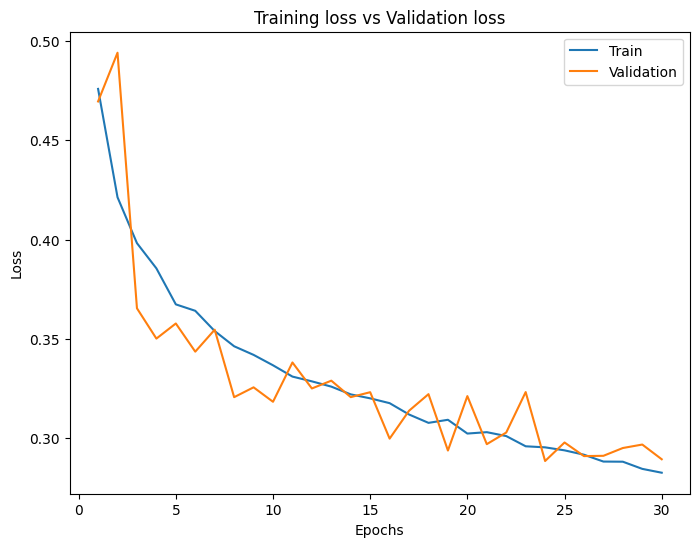

In [31]:
plot_loss_curve(train_loss_list, val_loss_list)

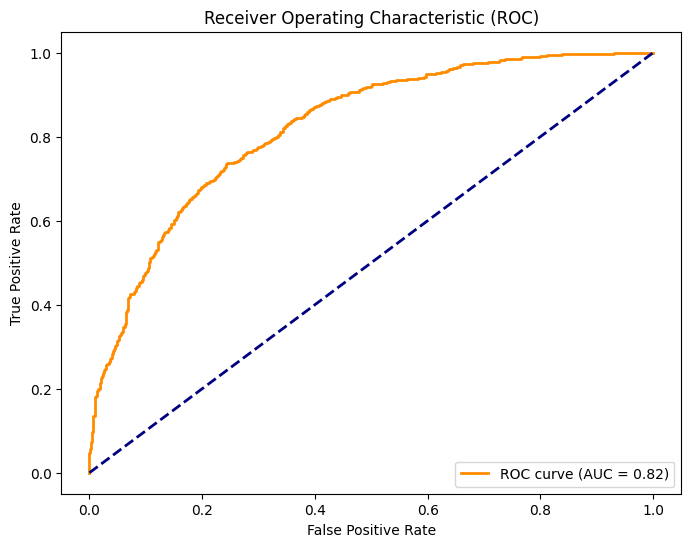

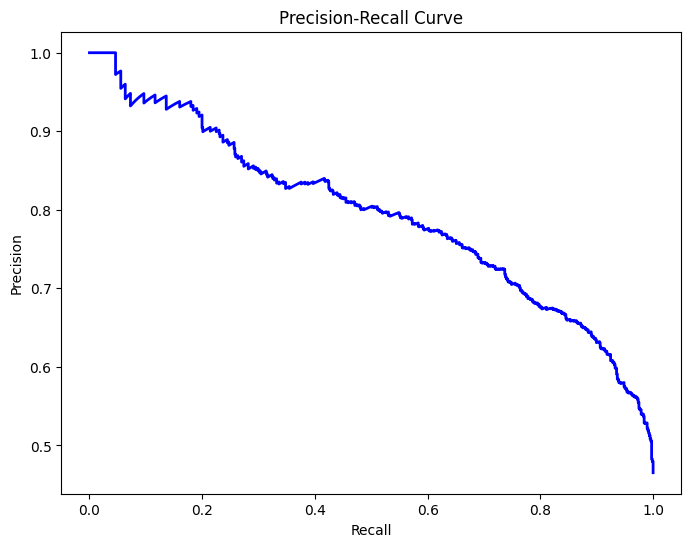

In [30]:
plot_roc_curve(all_labels, all_scores)
plot_precision_recall_curve(all_labels, all_scores)